# Time Series analysis for monthly milk production data

In [9]:

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv', sep=',',                            parse_dates=['Month'], index_col='Month')


# Rename columns
df.index.name = "Date"
df.rename(columns={"Monthly milk production (pounds per cow)":"Production"}, inplace=True)

df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


Or if you try an operation that's not defined:

ipykernel_launcher:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


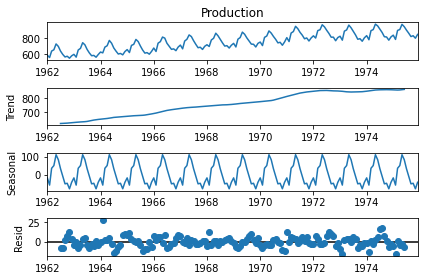

In [14]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Production'], freq=12)
decomposition.plot()
plt.show()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ax1 = 2
ax2 = 2
fig, ax = plt.subplots(ax1, ax2)
plot_acf(df, lags=50, ax=ax1)
plot_pacf(df, lags=50, ax=ax2)

AttributeError: 'int' object has no attribute 'figure'

In [18]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


P-value is greater than the threshold value, we fail to reject the null hypothesis and time series is non-stationary, it has time dependent component.
All these approaches suggest we have non-stationary data. Now, we need to find a way to make it stationary.
There are two major reasons behind non-stationary time series; trend and seasonality. We can apply differencing to make time series stationary by subtracting the previous observations from the current observations. Doing so we will eliminate trend and seasonality, and stabilize the mean of time series. Due to both trend and seasonal components, we apply one non-seasonal diff() and one seasonal differencing diff(12).

In [19]:
df_diff = df.diff().diff(12).dropna()

In [1]:
import pmdarima as pm
import six
#import sys
#sys.modules['sklearn.externals.six'] = six
model = pm.auto_arima(df['Production'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

ImportError: cannot import name 'six' from 'sklearn.externals' (C:\Users\sarawal\Anaconda3\envs\py37\lib\site-packages\sklearn\externals\__init__.py)

Here we see that when the error was raised in the ``try`` statement (in this case, a ``ZeroDivisionError``), the error was caught, and the ``except`` statement was executed.

One way this is often used is to check user input within a function or another piece of code.
For example, we might wish to have a function that catches zero-division and returns some other value, perhaps a suitably large number like $10^{100}$:

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['Production'],
                order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\sarawal\Anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sarawal\Anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Thu, 11 Mar 2021   AIC                           1066.207
Time:                                      17:55:29   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

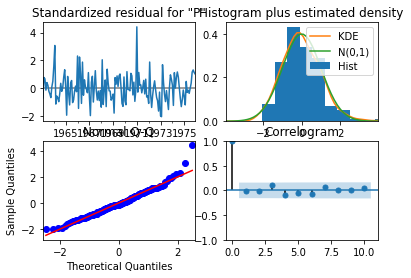

In [26]:
results.plot_diagnostics()
plt.show()

In [27]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

NameError: name 'test' is not defined

There is a subtle problem with this code, though: what happens when another type of exception comes up? For example, this is probably not what we intended:

In [28]:
from sklearn.metrics import r2_score
r2_score(test['Production'], predictions)

NameError: name 'test' is not defined

In [29]:

import numpy as np

mean_absolute_percentage_error = np.mean(np.abs(predictions - test['Production'])/np.abs(test['Production']))*100

NameError: name 'np' is not defined

In [30]:
results.get_forecast(steps=60)


As an example of where this might be useful, let's return to our ``fibonacci`` function that we defined previously: